In [110]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from plotly.offline import  iplot

Отключение warnings

In [72]:
warnings.filterwarnings('ignore')

Анализ типов данных и количества пропусков

In [73]:
df=pd.read_csv("data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Тепловая карта пропусков и их аоличество для каждого признака

PoolQC       1453
MiscFeature       1406
Alley       1369
Fence       1179
MasVnrType       872
FireplaceQu       690
LotFrontage       259
GarageType       81
GarageYrBlt       81
GarageFinish       81
GarageQual       81
GarageCond       81
BsmtExposure       38
BsmtFinType2       38
BsmtQual       37
BsmtCond       37
BsmtFinType1       37
MasVnrArea       8
Electrical       1


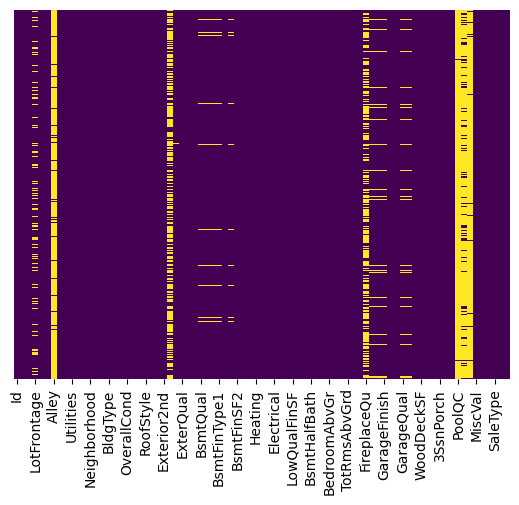

In [74]:
na_count=[]
for column in df.columns:
    na_count.append((column,np.count_nonzero(df[column].isnull())))
na_count.sort(key=lambda x:x[1],reverse=True)
for i in na_count:
    if i[1]==0:break
    print(i[0],'     ',i[1])

sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

Имеются колонки с большим и неочень колтчеством пропусков. Исходя из специфики данных, а так же малым количеством пропусков относительно количества информации в датасете, можно сделать предположение о эффективности заполения пропусков нулями. 

Далее описаны функции предобработки тренировачных и тестовых данных:

In [75]:
def preproc_x_train(x:pd.DataFrame,num_fillna,num_scaler:StandardScaler,obj_formater:OneHotEncoder):

    x_num = x.select_dtypes(['float64','int64'])
    x_num = (x_num.fillna(num_fillna(x_num)))
    x_num.index = range(len(x_num))

    x_obj = x.select_dtypes(['object']).fillna('Nan')
    obj_df_encode = obj_formater.fit_transform(x_obj)

    encode_columns=[]
    for column, postfixes in zip(x_obj.columns,obj_formater.categories_):
        for postfix in postfixes:
            encode_columns.append(str(column+'_'+str(postfix).replace(' ','_')))
    
    x_obj_formated = pd.DataFrame(obj_df_encode.toarray(),columns = encode_columns)
    x_train = pd.concat([x_num,x_obj_formated], axis = 1)
    x_train = pd.DataFrame(data=num_scaler.fit_transform(x_train),columns = x_train.columns)

    return x_train,num_scaler, obj_formater



def preproc_x_test(x:pd.DataFrame,num_fillna,num_scaler:StandardScaler,obj_formater:OneHotEncoder):

    x_num=x.select_dtypes(['float64','int64'])
    x_num=x_num.fillna(num_fillna(x_num))
    x_num.index=range(len(x_num))

    x_obj=x.select_dtypes(['object']).fillna('Nan')
    obj_df_encode = obj_formater.transform(x_obj)

    encode_columns=[]
    for column, postfixes in zip(x_obj.columns,obj_formater.categories_):
        for postfix in postfixes:
            encode_columns.append(str(column+'_'+str(postfix).replace(' ','_')))

    x_obj_formated=pd.DataFrame(obj_df_encode.toarray(),columns=encode_columns)

    x_test=pd.concat([x_num,x_obj_formated], axis=1)
    x_test=pd.DataFrame(data=num_scaler.transform(x_test),columns=x_test.columns)

    return x_test


def preprocess_y_train(y:pd.DataFrame,y_scaler:StandardScaler):
    y_test=pd.DataFrame(y_scaler.fit_transform(y), columns=['SalePrice'])
    return y_test,y_scaler
    

Разбиение данных на тренировочные и тестовые. Предобработка данных. 

In [114]:
train,test=train_test_split(df,test_size=0.3)

train=train.sort_values(by='SalePrice')
y_train=train['SalePrice']
x_train=train.drop(columns=['SalePrice','Id'])

y_test=test['SalePrice']
x_test=test.drop(columns=['SalePrice','Id'])

num_fillna=lambda x:0
num_scaler=StandardScaler()
obj_formater=OneHotEncoder(handle_unknown='ignore') 
pca_n_components=0
y_scaler=StandardScaler()

x_train_formated,num_scaler,obj_formater=preproc_x_train(x_train,num_fillna,num_scaler,obj_formater)
x_test_formated=preproc_x_test(x_test,num_fillna,num_scaler,obj_formater)
y_train_formated,y_scaler=preprocess_y_train(pd.DataFrame(y_train),y_scaler)


Анализ оптимального количества итоговых конмпонент PCA

In [77]:
score=[]
step=5

N=len(x_train_formated.columns)
for n in range(int(N/step)):
    n_comp=N-n*step
    formater=PCA(n_components=n_comp)
    formater.fit(x_train_formated)
    score.append(np.sum(formater.explained_variance_ratio_*n*step))

Визуализация спроектированное метрики эффективности понижения размерности методом PCA

BEST SCORE
Features count: 296
Drop components count: 205
Final featues count: 91
Press ratio: 0.6925675675675675
Saved info: 0.7485637836186996


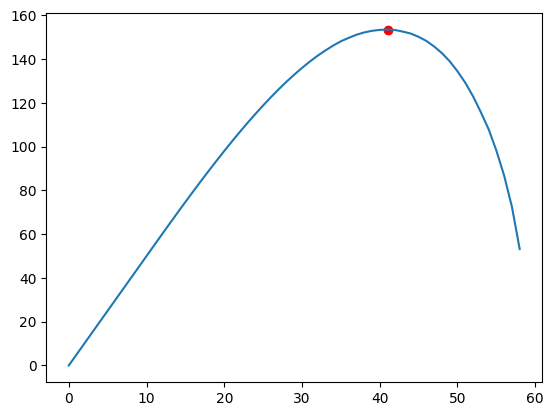

In [78]:
plt.plot(score)
drop_features=score.index(max(score))*step
best_pca=PCA(n_components=N-drop_features)
best_pca.fit(x_train_formated)

plt.scatter([drop_features/step],[np.sum(best_pca.explained_variance_ratio_*drop_features)],c='r')

print('BEST SCORE')
print('Features count:',N)
print('Drop components count:',drop_features)
print('Final featues count:', N-drop_features)
print('Press ratio:', drop_features/N)
print('Saved info:',np.sum(best_pca.explained_variance_ratio_))

Красной точкой обозначена точка экстремума, символизирующая оптимальное количество компонент.

Данный метод понижения размерности не был применен в конечном решении, однако оставил наработки для демонстрации спроектированной метрики.

<h2>Models.</h2>

Далее описана функция реализующая обучение модели и вычисление метрик

In [79]:
def fit_test(estimaror, param_grid,x_train,y_train,x_test,y_test,y_scaler:StandardScaler,cv=3):

    regressor=GridSearchCV(estimator=estimaror,param_grid=param_grid,cv=cv)
    regressor.fit(x_train, y_train)
    
    y_pred_train=y_scaler.inverse_transform(pd.DataFrame(regressor.predict(x_train)))
    train_mae=mean_absolute_error(y_scaler.inverse_transform(y_train), y_pred_train)
    train_r2=r2_score(y_scaler.inverse_transform(y_train), y_pred_train)


    y_pred_scale=regressor.predict(x_test)
    y_pred=y_scaler.inverse_transform(pd.DataFrame(y_pred_scale))
    test_mae=mean_absolute_error(y_test, y_pred)
    test_r2=r2_score(y_test, y_pred)

    print('Best params:', regressor.best_params_)
    print('Train MAE:', train_mae)
    print('Train R2:', train_r2)
    print('Test MAE:', test_mae)
    print('Test R2:', test_r2)

    return regressor, y_pred, test_mae, test_r2


Создаю словарь для записи метрик для разных моделей

In [80]:
metrics={}

<h3>Raw Linear Regrassion</h3>

In [81]:
print('Raw LinearRegression')
params={}
regressor,y_pred, test_mae, test_r2=fit_test(estimaror=LinearRegression(),
         param_grid=params,
         x_train=x_train_formated,
         y_train=y_train_formated,
         x_test=x_test_formated,
         y_test=y_test,
         y_scaler=y_scaler
       )

metrics['Raw LinearRegression']={'mae':test_mae,'r2':test_r2}

Raw LinearRegression
Best params: {}
Train MAE: 12060.157554452655
Train R2: 0.9519402683762834
Test MAE: 1.0517641672088404e+16
Test R2: -1.3396903784935418e+24


Некорректное поведение на тестовой выборке

<h3>Select features with Lasso</h3>

In [82]:
print('Lasso')
params={'alpha':np.linspace(0.01,0.1, 10)}
lasso_regressor, y_pred, test_mae, test_r2=fit_test(estimaror=Lasso(),
         param_grid=params,
         x_train=x_train_formated,
         y_train=y_train_formated,
         x_test=x_test_formated,
         y_test=y_test,
         y_scaler=y_scaler
       )

metrics['Lasso']={'mae':test_mae,'r2':test_r2}

Lasso
Best params: {'alpha': 0.020000000000000004}
Train MAE: 14627.885495770486
Train R2: 0.922331447605407
Test MAE: 16275.862782121107
Test R2: 0.8650210896302517


Адекватная отработка на тестовой выборке. Сходу хорошие значения метрик.

Вывод признаком и соответствующих весов в убывающем порядке:

In [83]:
coefs=pd.DataFrame(lasso_regressor.best_estimator_.coef_, x_test_formated.columns, columns=["coef"]).sort_values(by="coef", ascending=False)
coefs

,coef
GrLivArea,0.338414
OverallQual,0.164010
YearBuilt,0.106344
TotalBsmtSF,0.090951
KitchenQual_Ex,0.084121
...,...
KitchenAbvGr,-0.018433
BsmtExposure_No,-0.027862
ExterQual_TA,-0.036046
Condition2_PosN,-0.131256


Анализ изменения количества признаком при изменении порогового значения

In [84]:
t_array=np.arange(start=0,stop=float(max(abs(coefs['coef']))),step=0.002)
counts=[]
for t in t_array:
    counter=0
    for val in coefs.values: 
        if abs(val)>t:counter+=1
    counts.append(counter)

fig = go.Figure(data=go.Scatter(x=t_array, y=counts))
fig.show()

print('Not null weighted fetures: ', len(coefs[coefs['coef']!=0]))
print('All features:', len(coefs))
print('Not null weighted part:', np.round(len(coefs[coefs['coef']!=0])/len(coefs),2))

Not null weighted fetures:  57
All features: 296
Not null weighted part: 0.19


L1 занулил более 80% признаков. Для оставшися не наблюдается какого-то конкретного порога, по которому можно откинуть некогорые признаки.

Отбор признаков по весам используя порог t

In [85]:
#в данном случае 0
t=0.0                                                                                                          

final_num_columns=[]
for i,j in zip(coefs.index,coefs.values): 
    if abs(j)>t:final_num_columns.append(i)

print('Selected features:')
print(final_num_columns,'\n' ,'Count:',len(final_num_columns))

Selected features:
['GrLivArea', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'KitchenQual_Ex', 'ExterQual_Ex', 'BsmtQual_Ex', 'BsmtFinSF1', 'Neighborhood_NoRidge', 'RoofMatl_WdShngl', 'BldgType_1Fam', 'GarageArea', 'BsmtExposure_Gd', 'OverallCond', 'Neighborhood_NridgHt', 'Neighborhood_Crawfor', 'LotArea', 'Neighborhood_StoneBr', 'PoolQC_Ex', 'SaleType_New', 'YearRemodAdd', 'Functional_Typ', 'Fireplaces', 'Condition1_Norm', 'GarageCars', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'HeatingQC_Ex', 'ScreenPorch', 'MasVnrArea', 'LandContour_HLS', 'BsmtFullBath', 'BsmtFinType1_GLQ', 'GarageQual_Ex', 'Neighborhood_BrkSide', 'WoodDeckSF', 'LotConfig_CulDSac', 'SaleType_CWD', 'SaleType_Con', 'Foundation_PConc', 'GarageFinish_Fin', 'BsmtFinType2_ALQ', 'LotShape_IR2', 'KitchenQual_TA', 'GarageFinish_Unf', 'Condition1_Artery', 'BsmtQual_TA', 'Functional_Sev', 'LowQualFinSF', 'MSZoning_C_(all)', 'MSZoning_RM', 'SaleCondition_Abnorml', 'KitchenAbvGr', 'BsmtExposure_No', 'ExterQual_TA', 'Conditio

<h3>Отобранные признаки и интерпритация</h3>

Выше указаны отобраные признаки, можено заметить, что для котегориальных признаков определены конкретные значения, которые дают сильный вклад в предсказание. Например, RoofMatl (материал крыши) имеющий значение ClyTile, уменьшает стоимость дома, следовательно возможно перед продажей дома стоит оценить выгоду
замены крыши.

<h3>LinearRegression on Lasso passed features</h3>

In [86]:
print('LinearRegression')
params={}
regressor,y_pred, test_mae, test_r2=fit_test(estimaror=LinearRegression(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

metrics['LinearRegression']={'mae':test_mae,'r2':test_r2}

LinearRegression
Best params: {}
Train MAE: 13835.594389591708
Train R2: 0.9347476548296718
Test MAE: 17617.533069887206
Test R2: 0.841123700314379


НА отобранных признакал обычная линейная регрессия стала работать хорошо

<h3>Ridge on Lasso passed features</h3>

In [87]:
print('Ridge')
params={'alpha':np.linspace(100,1000, 10)}
regressor,y_pred, test_mae, test_r2=fit_test(estimaror=Ridge(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

metrics['Ridge']={'mae':test_mae,'r2':test_r2}

Ridge
Best params: {'alpha': 300.0}
Train MAE: 14852.893941172484
Train R2: 0.9178614834648147
Test MAE: 17613.664915798014
Test R2: 0.8631557125217801


Не наблюдаем прироста в прогнозируещей способности

<h3>DecisionTreeRegressor on Lasso passed features</h3>

In [88]:
print('DecisionTreeRegressor')
params={'max_depth':[10]}
regressor,y_pred, test_mae, test_r2=fit_test(estimaror=DecisionTreeRegressor(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

metrics['DecisionTreeRegressor']={'mae':test_mae,'r2':test_r2}

DecisionTreeRegressor
Best params: {'max_depth': 10}
Train MAE: 5033.628737039901
Train R2: 0.9881346412798107
Test MAE: 24937.623446453235
Test R2: 0.7432927091068671


Ничего пригодного, однако от простого дерева большего ждать не стоит

<h3>RandomForestRegressor on Lasso passed features</h3>

In [90]:
print('RandomForestRegressor')
params={'max_depth':[100],#np.arange(10,100,10),
        'n_estimators':[1000],#np.arange(10,100,10),
        'bootstrap':[True],
        'max_features':['sqrt'],
        'oob_score':[True]
        }
regressor,y_pred, test_mae, test_r2=fit_test(estimaror=RandomForestRegressor(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

metrics['RandomForestRegressor']={'mae':test_mae,'r2':test_r2}

RandomForestRegressor
Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 1000, 'oob_score': True}
Train MAE: 6348.2487954990465
Train R2: 0.9790664611415623
Test MAE: 15455.238603065873
Test R2: 0.8895697762617558


Наблюдается ощутимый прирост в метриках

<h3>XGBRegressor on Lasso passed features</h3>

In [89]:
print('XGBRegressor')
params={'max_depth':[4],#np.arange(1,10),
        'n_estimators':[200],#np.arange(1,100,10),
        "objective": ["reg:squarederror"],
        "learning_rate": [0.1],#np.arange(0.1,0.2,0.1),
        "subsample": [0.9],#np.arange(0.9,1.1,0.1),
        "colsample_bytree":[1],#np.arange(0.5,0.6,0.1),
        "colsample_bylevel":[1],#np.arange(0.8,0.9,0.1),
        "reg_lambda":[0.11],#np.arange(0.05,0.15,0.01),
        "eval_metric": ["rmse"],
        "random_state":[10],
}

regressor,y_pred, test_mae, test_r2=fit_test(estimaror=XGBRegressor(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

metrics['XGBRegressor']={'mae':test_mae,'r2':test_r2}

XGBRegressor
Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'reg:squarederror', 'random_state': 10, 'reg_lambda': 0.11, 'subsample': 0.9}
Train MAE: 5056.539138943249
Train R2: 0.9930853188067109
Test MAE: 14158.165150542238
Test R2: 0.9177999919345298


Бустинговый ансамбль превзащёл RandomForest и все остальные методы по целевым метрикам. Raw LinearRegression так как имеет некорректные метрики.
Все остальные модели обучены на признаках отобранных при помощи Lasso.
Так совпало что модели с лучшим MAE имеют лучший R2.

In [107]:
metrics_df=pd.DataFrame(metrics).drop(columns=['Raw LinearRegression']).T.sort_values(by='mae')
metrics_df

,mae,r2
XGBRegressor,14158.165151,0.917800
RandomForestRegressor,15455.238603,0.889570
Lasso,16275.862782,0.865021
Ridge,17613.664916,0.863156
LinearRegression,17617.533070,0.841124
DecisionTreeRegressor,24937.623446,0.743293


Визуализируем сравнение

In [113]:
trace0 = go.Bar(
    x=metrics_df.index,
    y=metrics_df['mae']/max(metrics_df['mae']),
    name='MAE'
)

trace1 = go.Bar(
    x=metrics_df.index,
    y=metrics_df['r2'],
    name='R2'
)

data = [trace0, trace1]
layout = {'title': 'Msdels scores', 'xaxis': {'title': 'Model'}}

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

У лучшей модели наименьшая MAE и больший R2 - всё как и должно быть.

<h3>Визуализация прогнозов. Сравнение предсказаний с тестовыми</h3>

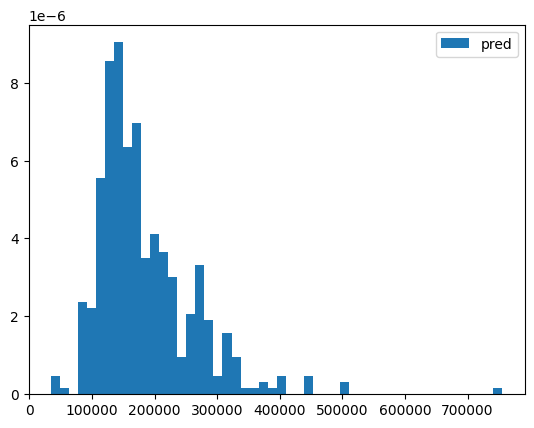

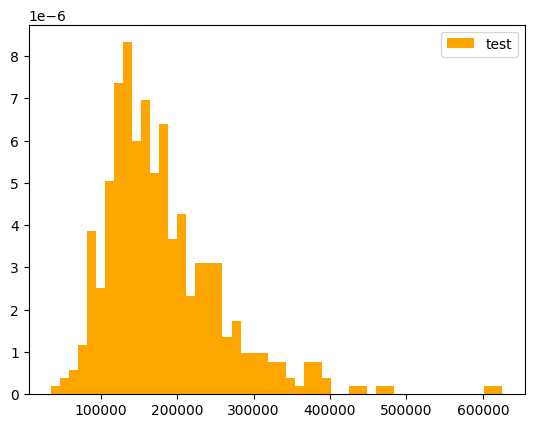

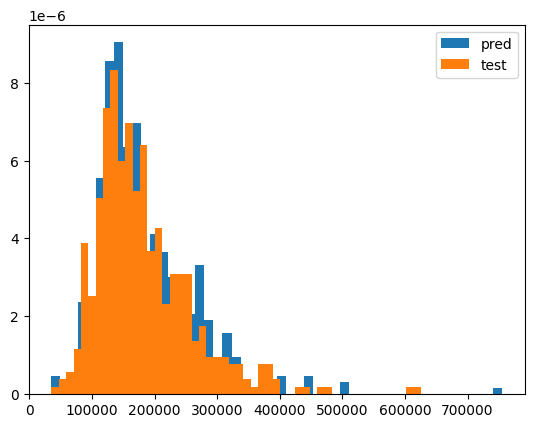

In [27]:
plt.figure()
plt.hist(y_pred,bins=50,density=True)
plt.legend(['pred'])

plt.figure()
plt.hist(y_test,bins=50,density=True,color='orange')
plt.legend(['test'])

plt.figure()
plt.hist(y_pred,bins=50,density=True)
plt.hist(y_test,bins=50,density=True)
plt.legend(['pred','test']);

При помощи построенных гистограмм частот можно убедится в том, что модель хорошо приближает тестовые данные

<h3>Несработавшие методики:</h3>

- MinMax уступил Zclal-ингу, если судить по целевым метрикам. 

- Метод главных компонент в данной задаче не дал выигрыша в итоговых метриках. Даже если бы выигрыш был (не существенный < ~ +0.05 R2), 
  выбор сделал бы выбор в сторону отбора L1 регуляризатором, так как полезна возможность интерпритации признаков.

- Применение OriginalEncoder (кодировка признаков от 0 до N равного количеству возможных значений) кажется разумным в данной задаче, так так в основном
  все категориальные признаки имеют значения, которые легко можно проранжировать по ценности, однако использование данного подхода не дало преемуществ перед 
  OneHot, если судить по метрикам. 

<h2>Creating answer</h2>

In [29]:
test_df=pd.read_csv('data/test.csv')

In [31]:
train=df.sort_values(by='SalePrice')
y_train=train['SalePrice']
x_train=train.drop(columns=['SalePrice','Id'])

x_test=test_df.drop(columns=['Id'])


num_fillna=lambda x:0
num_scaler=StandardScaler()
obj_formater=OneHotEncoder(handle_unknown='ignore')
pca_n_components=0
y_scaler=StandardScaler()

x_train_formated,num_scaler,obj_formater=preproc_x_train(x_train,num_fillna,num_scaler,obj_formater)
x_test_formated=preproc_x_test(x_test,num_fillna,num_scaler,obj_formater)
y_train_formated,y_scaler=preprocess_y_train(pd.DataFrame(y_train),y_scaler)

In [32]:
params={'max_depth':4,
        'n_estimators':1000,
        "objective": "reg:squarederror",
        "learning_rate": 0.1,
        "subsample": 0.9,
        "colsample_bytree":1,
        "colsample_bylevel":1,
        "reg_lambda":0.11,
        "eval_metric": "rmse",
        "random_state":1
}

regresssor=XGBRegressor(**params)
regresssor.fit(x_train_formated,y_train_formated)
y_pred_scaled=pd.DataFrame(regresssor.predict(x_test_formated))
y_pred=y_scaler.inverse_transform(y_pred_scaled)
saleprice=pd.DataFrame(y_pred,columns=['SalePrice'])
saleprice.index=range(1461,2920)
saleprice.to_csv('answer.csv')